### Surface model example

This example shows how to fit the model taking margin of victory and surface into account.

There is a set of convenient functions in `jax_elo.models.correlated_skills_model` which we will use for this.

In [1]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = ''
from jax_elo.models.correlated_skills_model import fit, calculate_ratings, predict, get_player_skill_history
from jax_elo.utils.data import get_data

In [2]:
# Change this to where your data is located.
# This uses Jeff Sackmann's dataset, which is available here:
# https://github.com/JeffSackmann/tennis_atp
data = get_data('/home/martin/data/tennis_atp/')

In [3]:
to_use = data[data['tourney_date'].dt.year >= 2010]
to_use = to_use[to_use['surface'] != 'Carpet']
to_use = to_use.dropna(subset=['spw_winner', 'spw_loser'])

In [4]:
# Compute the margin on the % of service points won
margins = to_use['spw_winner'] - to_use['spw_loser']

In [5]:
# Fit the model -- this might take a few minutes (but not more than that)
params, opt_info = fit(to_use['winner_name'], to_use['loser_name'], to_use['surface'].values, 
                       margins=margins.values, verbose=True)

theta: {'a1': 0.010000000000000002, 'a2': array(0.), 'sigma_obs': 0.1, 'cov_mat': DeviceArray([[10000.000001,     0.      ,     0.      ],
             [    0.      , 10000.000001,     0.      ],
             [    0.      ,     0.      , 10000.000001]], dtype=float64)}
cov_mat: [[10000.000001     0.           0.      ]
 [    0.       10000.000001     0.      ]
 [    0.           0.       10000.000001]]
theta: {'a1': Traced<ShapedArray(float64[])>with<JVPTrace(level=2/1)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/1)>, 'a2': Traced<ShapedArray(float64[])>with<JVPTrace(level=2/1)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/1)>, 'sigma_obs': Traced<ShapedArray(float64[])>with<JVPTrace(level=2/1)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
       t

theta: {'a1': 0.00012833005294173505, 'a2': array(0.10020474), 'sigma_obs': 0.08296399025849277, 'cov_mat': DeviceArray([[10578.73621481,  4387.85255167,  6639.74905087],
             [ 4387.85255167, 14398.16283808,  8090.89965811],
             [ 6639.74905087,  8090.89965811,  9665.25275223]],            dtype=float64)}
cov_mat: [[10578.73621481  4387.85255167  6639.74905087]
 [ 4387.85255167 14398.16283808  8090.89965811]
 [ 6639.74905087  8090.89965811  9665.25275223]]
theta: {'a1': 0.00012676603284449148, 'a2': array(0.10078032), 'sigma_obs': 0.08370150201448252, 'cov_mat': DeviceArray([[10514.92872006,  4617.09208106,  6556.23351309],
             [ 4617.09208106, 14626.23707211,  8245.62464527],
             [ 6556.23351309,  8245.62464527,  9128.48174622]],            dtype=float64)}
cov_mat: [[10514.92872006  4617.09208106  6556.23351309]
 [ 4617.09208106 14626.23707211  8245.62464527]
 [ 6556.23351309  8245.62464527  9128.48174622]]
theta: {'a1': 0.00012822036430914445, 'a2'

theta: {'a1': 0.00014026552909888966, 'a2': array(0.09960555), 'sigma_obs': 0.08338211251860339, 'cov_mat': DeviceArray([[ 8623.74729547,  4253.32715963,  5373.00526566],
             [ 4253.32715963, 10779.27592   ,  7049.64421628],
             [ 5373.00526566,  7049.64421628,  6891.86418617]],            dtype=float64)}
cov_mat: [[ 8623.74729547  4253.32715963  5373.00526566]
 [ 4253.32715963 10779.27592     7049.64421628]
 [ 5373.00526566  7049.64421628  6891.86418617]]
theta: {'a1': 0.0001402437568732272, 'a2': array(0.09961194), 'sigma_obs': 0.08338481515853477, 'cov_mat': DeviceArray([[ 8626.92281367,  4253.84687626,  5375.0336087 ],
             [ 4253.84687626, 10775.82052084,  7049.87284422],
             [ 5375.0336087 ,  7049.87284422,  6891.55547721]],            dtype=float64)}
cov_mat: [[ 8626.92281367  4253.84687626  5375.0336087 ]
 [ 4253.84687626 10775.82052084  7049.87284422]
 [ 5375.0336087   7049.87284422  6891.55547721]]
theta: {'a1': 0.00014023910711765837, 'a2':

In [6]:
# The parameters found are:
params

EloParams(theta={'a1': 0.00014024650276876443, 'a2': array(0.09961149), 'sigma_obs': 0.08338470228795589, 'cov_mat': DeviceArray([[ 8627.30531313,  4243.7595162 ,  5373.37062124],
             [ 4243.7595162 , 10776.60123434,  7050.64881994],
             [ 5373.37062124,  7050.64881994,  6889.66094134]],            dtype=float64)})

In [7]:
# We can now calculate the rating history:
history, final_rating_dict, mark_names = calculate_ratings(params, to_use['winner_name'], to_use['loser_name'],
                                                           to_use['surface'].values, margins.values)

100%|██████████| 26149/26149 [00:05<00:00, 4400.32it/s]


In [8]:
# Here's an example entry:
history[-1]

{'winner': 'Thiago Seyboth Wild',
 'loser': 'Casper Ruud',
 'winner_prior_mean': {'Clay': 1583.8764297219504,
  'Grass': 1541.2586994314147,
  'Hard': 1552.2410100169593},
 'loser_prior_mean': {'Clay': 1840.3531600014626,
  'Grass': 1633.6345489346418,
  'Hard': 1683.138800720313},
 'winner_prior_prob': 0.20846658704332177,
 'cur_mark': 'Clay'}

In [9]:
# We can predict matches on a particular surface
predict(final_rating_dict, params, 'Roger Federer', 'Tennys Sandgren', 'Hard', mark_names)

0.9338042575283267

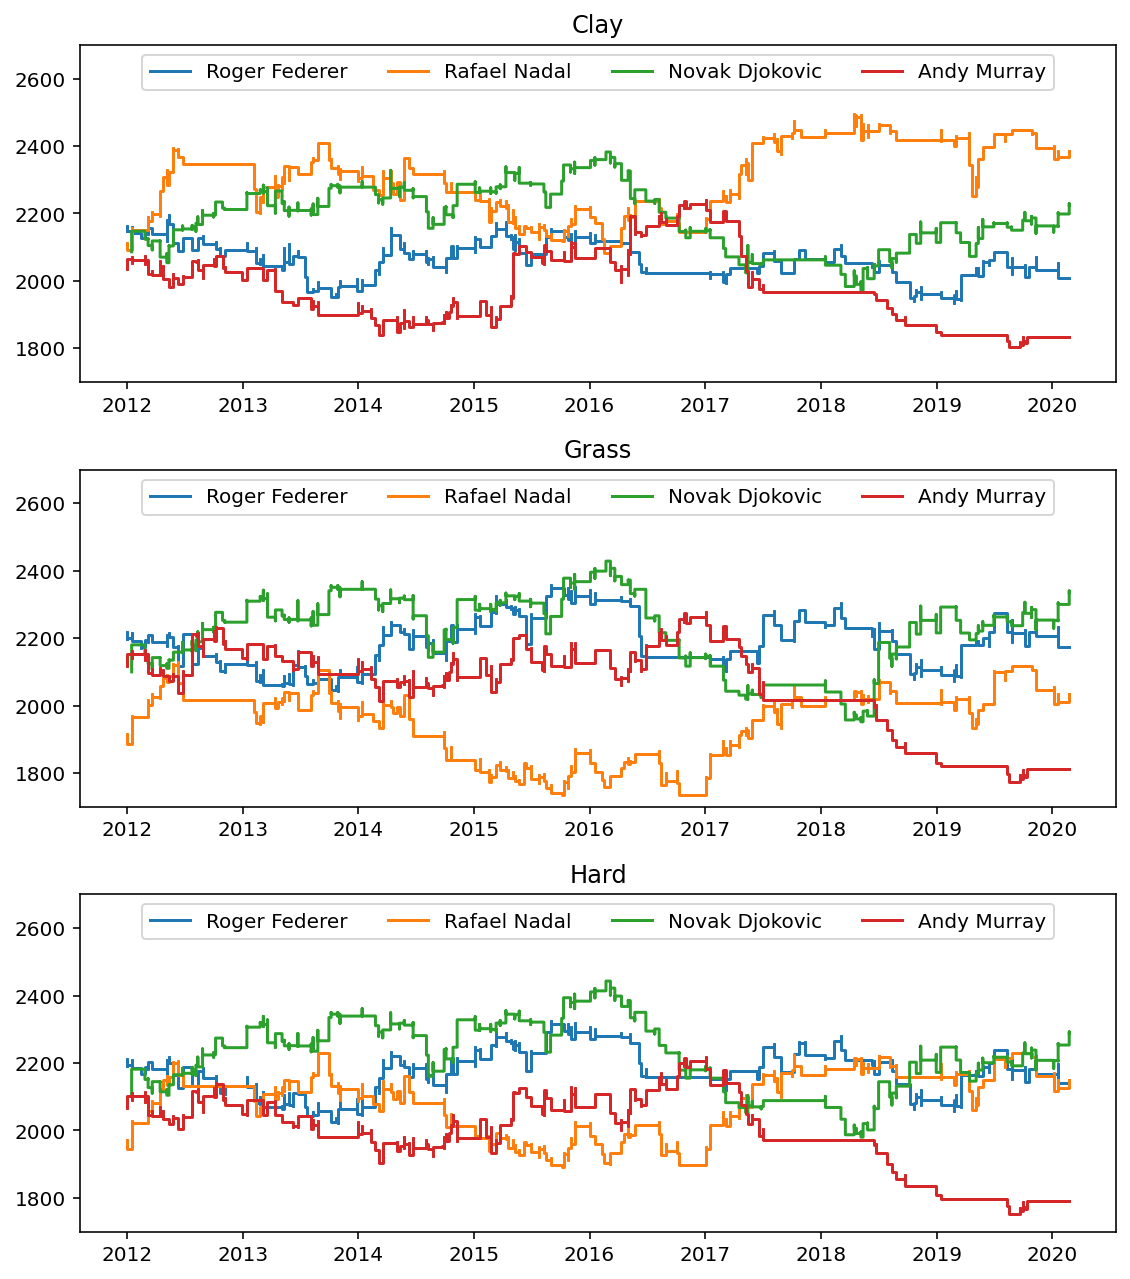

In [10]:
# We can plot the ratings over time:
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(len(mark_names), 1)

start_year = 2012

for cur_player in ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic', 'Andy Murray']:

    cur_history = get_player_skill_history(history, final_rating_dict, to_use['tourney_date'].values, cur_player)
    cur_history = cur_history[cur_history.index >= f'{start_year}-01-01']
    
    for cur_surface, cur_ax in zip(mark_names, ax.reshape(-1)):
        cur_ax.step(cur_history.index, cur_history[cur_surface].values, label=cur_player)
        cur_ax.legend(ncol=4, loc='upper center')
        cur_ax.set_title(cur_surface)
        cur_ax.set_ylim(1700, 2700)

f.set_size_inches(8, 9)
f.tight_layout()


In [11]:
# We can look at the marginal standard deviations on each surface
import numpy as np
import pandas as pd

prior_sd = pd.Series(np.sqrt(np.diag(params.theta['cov_mat'])), mark_names)
print(prior_sd)

Clay      92.883289
Grass    103.810410
Hard      83.003981
dtype: float64


In [12]:
# Finally, we can look at the correlation matrix between surface results
def covar_to_corr(covar_mat):
    # Turns a covariance matrix into a correlation matrix

    marg_var = np.diag(covar_mat)
    marg_sd = np.sqrt(marg_var)
    inv_marg = np.diag(1. / marg_sd)

    return np.dot(np.dot(inv_marg, covar_mat), inv_marg)

corr_mat = covar_to_corr(params.theta['cov_mat'])

In [13]:
pd.DataFrame(corr_mat, index=mark_names, columns=mark_names).round(3)

,Clay,Grass,Hard
Clay,1.000,0.440,0.697
Grass,0.440,1.000,0.818
Hard,0.697,0.818,1.000


In [14]:
win_probs = np.stack([x['winner_prior_prob'] for x in history])
np.mean(np.log(win_probs))

-0.590121118586947

In [15]:
# Compare with Elo:
from jax_elo.utils.elo import optimise_static_k, compute_elo_ratings

In [16]:
k, _ = optimise_static_k(to_use['winner_name'].values, to_use['loser_name'].values)

In [17]:
elo_results = pd.DataFrame(compute_elo_ratings(to_use['winner_name'].values, to_use['loser_name'].values, lambda _: k))

In [18]:
# Standard Elo has a lower log likelihood:
np.mean(np.log(elo_results['winner_prob']))

-0.6032609200891181

In [19]:
# Accuracy
np.mean(elo_results['winner_prob'] > 0.5)

0.6626639642051321